Preprocessing 
---

This notebook takes the merged and selected data exported at the end of the EDA notebook and prepares it for use by the models. It creates a series of bools for each tweet, recording the locations, languages, and the game referenced via hashtag. It then resamples the data by minute, turning these bools into an average: the fraction of tweets in that minute with that parameter. It then measures the tweet rate by counting the total number of tweets in that minute.

The data is exported for direct use by the models.

---
# Setup

## Import libraries, data, and dictionaries

In [36]:
import pandas as pd
import numpy as np
import json
import ast
import re

import matplotlib.pyplot as plt

In [3]:
# import data
data_for_preprocessing_path = './merged_data/data_for_preprocessing.csv'
df = pd.read_csv(data_for_preprocessing_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386457 entries, 0 to 386456
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          386457 non-null  int64 
 1   lang                386457 non-null  object
 2   possibly_sensitive  386457 non-null  object
 3   source              386457 non-null  object
 4   text                386457 non-null  object
 5   created_at          386457 non-null  object
 6   location            299526 non-null  object
 7   win                 386457 non-null  object
 8   is_poke             386457 non-null  object
 9   broad_location      386408 non-null  object
 10  hashtags            386457 non-null  object
 11  has_hashtags        386457 non-null  bool  
dtypes: bool(1), int64(1), object(10)
memory usage: 32.8+ MB


In [4]:
# import dictionaries
hashtag_to_game_path = './EDA/hashtag_to_game.json'
with open(hashtag_to_game_path, 'r') as this_file:
    hashtag_to_game = json.loads(this_file.read())

locs_path = './EDA/loc_dict.json'
with open(locs_path, 'r') as file:
    locs = json.loads(file.read())

---
# Create columns for lang

Use the lang dictionary to create individual columns for specific languages.

In [9]:
#import the dictionary
with open('./iso_639-1.json', 'r', encoding='utf-8') as lang_file:
    lang_dict = json.load(lang_file)
lang_dict['und'] = {'name':'undefined'}
lang_dict['in'] = lang_dict['id'] #filling in some some the twitter column coded differently in the dictionary
lang_dict['iw'] = lang_dict['he']

In [10]:
#get a list of the named languages
top_languages = df['lang'].apply(lambda this_lang: lang_dict[this_lang]['name'] if this_lang in lang_dict.keys() else 'undefined').value_counts()
#cut that list into top 25, not including (undefined)
top_languages = top_languages[:26].index
top_languages

Index(['English', 'Japanese', 'Spanish', 'undefined', 'Turkish', 'French',
       'Korean', 'German', 'Catalan', 'Russian', 'Estonian', 'Thai', 'Tagalog',
       'Dutch', 'Czech', 'Portuguese', 'Indonesian', 'Chinese', 'Finnish',
       'Norwegian', 'Romanian', 'Italian', 'Arabic', 'Danish', 'Welsh',
       'Swedish'],
      dtype='object')

In [11]:
%%time
# create a column in the data for each of these. A manual pd.get_dummies.
for index in top_languages:
    df['language_is_' + index] = df['lang'].apply(lambda this_lang: this_lang == index if this_lang in top_languages else False)

Wall time: 4.64 s


In [12]:
#verify the columns were made.
df.columns

Index(['Unnamed: 0', 'lang', 'possibly_sensitive', 'source', 'text',
       'created_at', 'location', 'win', 'is_poke', 'broad_location',
       'hashtags', 'has_hashtags', 'language_is_English',
       'language_is_Japanese', 'language_is_Spanish', 'language_is_undefined',
       'language_is_Turkish', 'language_is_French', 'language_is_Korean',
       'language_is_German', 'language_is_Catalan', 'language_is_Russian',
       'language_is_Estonian', 'language_is_Thai', 'language_is_Tagalog',
       'language_is_Dutch', 'language_is_Czech', 'language_is_Portuguese',
       'language_is_Indonesian', 'language_is_Chinese', 'language_is_Finnish',
       'language_is_Norwegian', 'language_is_Romanian', 'language_is_Italian',
       'language_is_Arabic', 'language_is_Danish', 'language_is_Welsh',
       'language_is_Swedish'],
      dtype='object')

---
# Create columns for game type

## is wordle

Having exactly the format of a Wordle post will automatically assign is_wordle = True to a tweet. Determine this with a regex search.

In [13]:
#look at some texts
df['text']

0              Wordle 314 4/6\n\n🟩⬛🟩🟨🟨\n🟩🟩🟩⬛🟨\n🟩🟩🟩🟩⬛\n🟩🟩🟩🟩🟩
1                  😈💅😈💅😈💅\n\nWordle 314 2/6\n\n🟩⬛🟩🟨🟨\n🟩🟩🟩🟩🟩
2         Wordle 315 4/6\n\n⬜⬜🟨⬜⬜\n⬜⬜⬜🟨⬜\n⬜⬜⬜⬜⬜\n🟩🟩🟩🟩🟩\n...
3         this is the best I've done so far \n\nWordle 3...
4         最近はめっきり知らない単語ばっかり。\n\nWordle 315 5/6\n\n⬛⬛⬛🟨⬛\...
                                ...                        
386452                Wordle 320 3/6\n\n🟩🟩⬜⬜🟨\n🟩🟩⬜🟩⬜\n🟩🟩🟩🟩🟩
386453    Wordle 320 5/6\n\n⬜🟨⬜⬜🟨\n🟩⬜🟨⬜⬜\n🟩🟩⬜🟩🟩\n🟩🟩⬜🟩🟩\n...
386454    Wordle (ES)  #119 6/6\n\n🟨⬜🟩⬜🟩\n⬜🟩🟩⬜🟩\n⬜🟩🟩⬜🟩\n...
386455    @marcusreif Wördl 320 6/6 🔥3\n\n⬜⬜⬜🟨⬜\n🟨🟨⬜🟨⬜\n...
386456         Wordle 320 4/6\n\n🟨🟨⬛⬛⬛\n⬛🟩⬛🟩🟩\n⬛🟩⬛🟩🟩\n🟩🟩🟩🟩🟩
Name: text, Length: 386457, dtype: object

In [15]:
#create a column if r'^Wordle xxx x/x' matches in the text
wordle_regex = r'^Wordle [0-9]{1,3} [0-6]{1}/[0-6]{1}'
df['is_wordle'] = df['text'].apply(lambda this_text: len(re.findall(wordle_regex, this_text))>0)

# how many of these tweets are wordles proper via this method?
df['is_wordle'].mean()

0.6019220767122863

This assigned about 60% of the tweets as legitimate Wordles.

## Create columns for game type from hashtags

In [16]:
%%time
#turn object hashtag series into lists
hashtag_list = df['hashtags'].apply(lambda these_hashtags: ast.literal_eval(these_hashtags))

Wall time: 2.44 s


In [17]:
# look at hashtag_to_game conversion dictionary
hashtag_to_game

{'ポケモンWordle': 'JPPokemon',
 'Wordle': 'Wordle',
 'wordle': 'Wordle',
 'WordleCAT': 'Catalan',
 'вордли': 'Russian',
 'Heardle': 'Heardle',
 '워들': 'Korean',
 '한글': 'Korean',
 'Korean': 'Korean',
 'wordleTR': 'Turkish',
 'AlWird': 'Arabic',
 'galego': 'Galego',
 'WordleGalego': 'Galego',
 'DailyWordleClub': 'WordleNYT',
 'WordleEnglish': 'WordleNYT',
 'WordleEN': 'WordleNYT',
 'WordleEUS': 'Basque',
 'hadesjSlova': 'Czech',
 'WORDLE_TAMIL': 'Tamil',
 'WizardingWordle': 'Wizard',
 'Enstarsdle': 'Enstars',
 'WordleEspañol': 'Spanish',
 'wordleES': 'Spanish',
 '嘘wordle': 'Japanese',
 '百人一首Wordle': 'Japanese',
 'Quordle': 'Quordle',
 'ことのはたんご': 'kotonoha-tango',
 'NYTimes': 'WordleNYT'}

In [18]:
# create a column in the data for each of these. A manual pd.get_dummies with multiple values in a list.
for key in hashtag_to_game.keys():
    df['game_from_hashtag_' + key] = df['hashtags'].apply(lambda this_hashtag_list: key in this_hashtag_list)


In [20]:
#verify the columns were made
df.columns

Index(['Unnamed: 0', 'lang', 'possibly_sensitive', 'source', 'text',
       'created_at', 'location', 'win', 'is_poke', 'broad_location',
       'hashtags', 'has_hashtags', 'language_is_English',
       'language_is_Japanese', 'language_is_Spanish', 'language_is_undefined',
       'language_is_Turkish', 'language_is_French', 'language_is_Korean',
       'language_is_German', 'language_is_Catalan', 'language_is_Russian',
       'language_is_Estonian', 'language_is_Thai', 'language_is_Tagalog',
       'language_is_Dutch', 'language_is_Czech', 'language_is_Portuguese',
       'language_is_Indonesian', 'language_is_Chinese', 'language_is_Finnish',
       'language_is_Norwegian', 'language_is_Romanian', 'language_is_Italian',
       'language_is_Arabic', 'language_is_Danish', 'language_is_Welsh',
       'language_is_Swedish', 'is_wordle', 'game_from_hashtag_ポケモンWordle',
       'game_from_hashtag_Wordle', 'game_from_hashtag_wordle',
       'game_from_hashtag_WordleCAT', 'game_from_hashtag_во

# Create columns for broad locations

Locations have already been divided into broader locations with `broad_location`.

In [22]:
#create columns for top 25 broad locations (besides undefined)
top_broad_locations = df['broad_location'].value_counts().index[:26]
top_broad_locations

Index(['undefined', 'USAE', 'UK', 'JPN', 'ES', 'USAC', 'USA', 'USAW', 'IN',
       'ASTL', 'CAE', 'AR', 'USAM', 'IE', 'TK', 'CA', 'MX', 'PH', 'NZ', 'CL',
       'SA', 'EUR', 'CAW', 'MY', 'CAM', 'CO'],
      dtype='object')

In [23]:
%%time
# create a column in the data for each of these. A manual pd.get_dummies.
for index in top_broad_locations:
    df['broad_location_is_' + index] = df['broad_location'].apply(lambda this_broad_location: this_broad_location == index if this_broad_location in top_broad_locations else False)


Wall time: 5.13 s


In [24]:
# verify the new columns were created.
df.columns

Index(['Unnamed: 0', 'lang', 'possibly_sensitive', 'source', 'text',
       'created_at', 'location', 'win', 'is_poke', 'broad_location',
       'hashtags', 'has_hashtags', 'language_is_English',
       'language_is_Japanese', 'language_is_Spanish', 'language_is_undefined',
       'language_is_Turkish', 'language_is_French', 'language_is_Korean',
       'language_is_German', 'language_is_Catalan', 'language_is_Russian',
       'language_is_Estonian', 'language_is_Thai', 'language_is_Tagalog',
       'language_is_Dutch', 'language_is_Czech', 'language_is_Portuguese',
       'language_is_Indonesian', 'language_is_Chinese', 'language_is_Finnish',
       'language_is_Norwegian', 'language_is_Romanian', 'language_is_Italian',
       'language_is_Arabic', 'language_is_Danish', 'language_is_Welsh',
       'language_is_Swedish', 'is_wordle', 'game_from_hashtag_ポケモンWordle',
       'game_from_hashtag_Wordle', 'game_from_hashtag_wordle',
       'game_from_hashtag_WordleCAT', 'game_from_hashtag_во

About 75% of tweets are not assigned to one of the top 25 broad locations.

### Drop unneeded columns

These include "undefined" dummy columns.

In [25]:
#drop em
df.drop(columns = ['Unnamed: 0',
         'lang',
         'possibly_sensitive',
         'source',
         'text', 
         'location', 
         'win', 
         'is_poke',
         'broad_location',
         'hashtags',
         'has_hashtags',
         'broad_location_is_undefined',
         'language_is_undefined'
        ],
       inplace = True)

In [26]:
# verify they were dropped
df.columns

Index(['created_at', 'language_is_English', 'language_is_Japanese',
       'language_is_Spanish', 'language_is_Turkish', 'language_is_French',
       'language_is_Korean', 'language_is_German', 'language_is_Catalan',
       'language_is_Russian', 'language_is_Estonian', 'language_is_Thai',
       'language_is_Tagalog', 'language_is_Dutch', 'language_is_Czech',
       'language_is_Portuguese', 'language_is_Indonesian',
       'language_is_Chinese', 'language_is_Finnish', 'language_is_Norwegian',
       'language_is_Romanian', 'language_is_Italian', 'language_is_Arabic',
       'language_is_Danish', 'language_is_Welsh', 'language_is_Swedish',
       'is_wordle', 'game_from_hashtag_ポケモンWordle', 'game_from_hashtag_Wordle',
       'game_from_hashtag_wordle', 'game_from_hashtag_WordleCAT',
       'game_from_hashtag_вордли', 'game_from_hashtag_Heardle',
       'game_from_hashtag_워들', 'game_from_hashtag_한글',
       'game_from_hashtag_Korean', 'game_from_hashtag_wordleTR',
       'game_from_has

# Create general tweet rate

In [29]:
# turn created_at strings back into datetimes.
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

#each tweet counts as one. This is for counting totals.
df['ones'] = 1

In [30]:
#resample by minute
ts = df.resample(rule = 'T', on = 'created_at')

Take the mean of the booleans, but the _sum_ of the ones for a count.

In [33]:
#create mean of bools
ts_df = ts.mean().drop(columns = 'ones')

#tack on the total number of tweets
ts_df['total_tweets'] = ts['ones'].sum()

#check that it worked.
ts_df.head()

,language_is_English,language_is_Japanese,language_is_Spanish,language_is_Turkish,language_is_French,language_is_Korean,language_is_German,language_is_Catalan,language_is_Russian,language_is_Estonian,...,broad_location_is_PH,broad_location_is_NZ,broad_location_is_CL,broad_location_is_SA,broad_location_is_EUR,broad_location_is_CAW,broad_location_is_MY,broad_location_is_CAM,broad_location_is_CO,total_tweets
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 19:46:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,2
2022-04-29 19:47:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,15
2022-04-29 19:48:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.05,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,20
2022-04-29 19:49:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.066667,0.0,15
2022-04-29 19:50:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,15


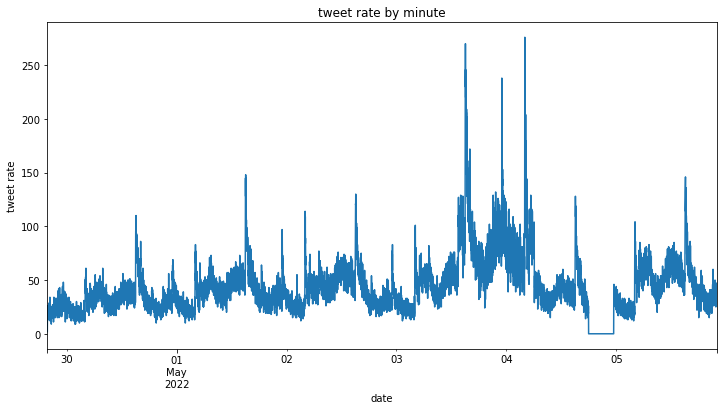

In [38]:
#plot the total tweet rate to verify
ts_df['total_tweets'].plot(figsize = (12,6))
plt.title("tweet rate by minute")
plt.ylabel("tweet rate")
plt.xlabel("date");

The missing region at the end of May 4th inot the 5th couldn't be filled at publication time. The Twitter 7-day API search window had already passed. Oh well.

# Create Columns for times

In [39]:
#create minute column
ts_df['minute'] = ts_df.index.minute

In [40]:
#create hour column
ts_df['hour'] = ts_df.index.hour

# Create lagged rates

Copy tweet rate values from 10 to 19 minutes before present, as well as a 20-minute wide window around the same time yesterday.

In [41]:
#copy recent lagged tweet rates
for lag_minutes in range(10,20):
    ts_df['lag_'+str(lag_minutes)] = ts_df['total_tweets'].shift(lag_minutes)

#copy 1-day lagged tweet rates
for lag_minutes in range(-10,11):
    ts_df['lag_day_'+str(lag_minutes)] = ts_df['total_tweets'].shift(60*24+lag_minutes)

# Export for use by models

In [47]:
#save them in processed_data
processed_data_path = './processed_data/processed_data.csv'
ts_df.to_csv(processed_data_path)

# Next Step: Modeling

This data is used by the [next notebook](./5_models.ipynb) for modeling, with values before the May 4 gap as the training set and those after as the test set. The models are a collection of neural networks with varying depths, stopping patiences, and combinations of the data.